In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, accuracy_score

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set paths based on your Google Drive structure
base_dir = '/content/drive/My Drive/medical_scan-main'
images_folder = os.path.join(base_dir, 'brain_scan_images')
dataset_csv = os.path.join(base_dir, 'brain_scan_dataset.csv')

# Load dataset
df = pd.read_csv(dataset_csv)

# Display initial dataset info
print(f"Dataset shape before preprocessing: {df.shape}")
print(df['Scan Type(s)'].value_counts())

Mounted at /content/drive
Dataset shape before preprocessing: (1000, 5)
Scan Type(s)
CT                                                  395
Unknown                                             145
CT, MRI, MR                                         107
MRI, MR                                              61
Tomography                                           60
CT, Tomography                                       58
CT, MRI, Magnetic resonance, MR                      20
CT, PET                                              15
Magnetic resonance                                   13
CT, MRI, PET, MR                                     11
CT, MR                                               11
CT, Magnetic resonance                               10
CT, Tomography, Magnetic resonance                   10
Tomography, Magnetic resonance                        9
MR                                                    9
CT, MRI, Tomography, Magnetic resonance, MR           7
PET                

In [ ]:
# Remove rows with 'Unknown' scan type
df = df[~df['Scan Type(s)'].str.contains('Unknown', na=False)]
print(f"Dataset shape after removing Unknown scan types: {df.shape}")

# Function to process scan types (handle multiple scan types)
def process_scan_types(scan_types_str):
    if pd.isna(scan_types_str):
        return []

    # Split on commas and clean up whitespace
    scan_types = [t.strip() for t in scan_types_str.split(',')]
    return scan_types

# Extract scan types as a list for each image
df['scan_types_list'] = df['Scan Type(s)'].apply(process_scan_types)

# Count the number of scan types per image
df['num_scan_types'] = df['scan_types_list'].apply(len)
print(f"Images with multiple scan types: {(df['num_scan_types'] > 1).sum()}")

# Get all unique scan types
all_scan_types = []
for types in df['scan_types_list']:
    all_scan_types.extend(types)
unique_scan_types = sorted(set(all_scan_types))
print(f"Unique scan types: {unique_scan_types}")

# Create multi-label encoding
mlb = MultiLabelBinarizer()
scan_type_encoded = mlb.fit_transform(df['scan_types_list'])
print(f"Shape of encoded labels: {scan_type_encoded.shape}")
print(f"Label classes: {mlb.classes_}")

# Verify image files exist
image_files = [os.path.join(images_folder, f) for f in df['Image Name']]
valid_indices = [i for i, f in enumerate(image_files) if os.path.exists(f)]
print(f"Found {len(valid_indices)} valid images out of {len(image_files)}")

# Keep only rows with valid image files
df = df.iloc[valid_indices].reset_index(drop=True)
scan_type_encoded = scan_type_encoded[valid_indices]

Dataset shape after removing Unknown scan types: (855, 5)
Images with multiple scan types: 370
Unique scan types: ['CT', 'FDG-PET', 'MR', 'MRI', 'Magnetic resonance', 'Microscopy', 'PET', 'Photographs', 'Tomography', 'Ultrasound', 'Video', 'X-ray', 'computed-tomography']
Shape of encoded labels: (855, 13)
Label classes: ['CT' 'FDG-PET' 'MR' 'MRI' 'Magnetic resonance' 'Microscopy' 'PET'
 'Photographs' 'Tomography' 'Ultrasound' 'Video' 'X-ray'
 'computed-tomography']
Found 855 valid images out of 855


<ipython-input-2-8c84d5c721a5>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['scan_types_list'] = df['Scan Type(s)'].apply(process_scan_types)
<ipython-input-2-8c84d5c721a5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_scan_types'] = df['scan_types_list'].apply(len)


In [ ]:
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    """Load and preprocess an image for model input"""
    try:
        img = Image.open(image_path)
        img = img.resize(target_size)
        img = img.convert('RGB')  # Ensure 3 channels
        img_array = np.array(img) / 255.0  # Normalize to [0,1]
        return img_array
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

def create_dataset(dataframe, image_dir, encoded_labels, batch_size=32):
    """Create a TensorFlow dataset from image paths and labels"""
    image_paths = [os.path.join(image_dir, name) for name in dataframe['Image Name']]

    # Create dataset of image paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, encoded_labels))

    # Map function to load and preprocess images
    def load_image_wrapper(path, label):
        img = tf.py_function(
            lambda p: load_and_preprocess_image(p.numpy().decode('utf-8')),
            [path],
            tf.float32
        )
        img.set_shape([224, 224, 3])
        return img, label

    # Apply the mapping function
    dataset = dataset.map(load_image_wrapper, num_parallel_calls=tf.data.AUTOTUNE)

    # Batch and prefetch for performance
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

# Check class distribution to identify rare classes
class_counts = np.sum(scan_type_encoded, axis=0)
print("Class distribution:", class_counts)
min_class_count = np.min(class_counts)
print(f"Minimum class count: {min_class_count}")

# Split data into train and validation sets without stratification if any class has only 1 sample
if min_class_count < 2:
    print("Some classes have fewer than 2 samples. Using random split without stratification.")
    X_train, X_val, y_train, y_val = train_test_split(
        df['Image Name'],
        scan_type_encoded,
        test_size=0.2,
        random_state=42,
        stratify=None  # No stratification
    )
else:
    print("Using stratified split.")
    X_train, X_val, y_train, y_val = train_test_split(
        df['Image Name'],
        scan_type_encoded,
        test_size=0.2,
        random_state=42,
        stratify=scan_type_encoded
    )

# Create DataFrames for training and validation
train_df = pd.DataFrame({'Image Name': X_train}).reset_index(drop=True)
val_df = pd.DataFrame({'Image Name': X_val}).reset_index(drop=True)

# Check class distribution in train and validation sets
print("Train set class distribution:", np.sum(y_train, axis=0))
print("Validation set class distribution:", np.sum(y_val, axis=0))

# Create TF datasets
train_dataset = create_dataset(train_df, images_folder, y_train)
val_dataset = create_dataset(val_df, images_folder, y_val)

Class distribution: [681   9 255 227  84   5  51   1 160   5   2   5   1]
Minimum class count: 1
Some classes have fewer than 2 samples. Using random split without stratification.
Train set class distribution: [541   8 205 180  64   5  38   1 127   5   1   2   1]
Validation set class distribution: [140   1  50  47  20   0  13   0  33   0   1   3   0]


In [ ]:
def build_model(input_shape=(224, 224, 3), num_classes=len(mlb.classes_)):
    """Build a transfer learning model for multi-label classification"""
    # Load pre-trained base model (ResNet50)
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Multi-label classification: use sigmoid activation for each class
    outputs = Dense(num_classes, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=outputs)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Build the model
model = build_model(num_classes=len(mlb.classes_))
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,771,469 (94.50 MB)

 Trainable params: 1,183,757 (4.52 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 262s 11s/step - accuracy: 0.5128 - loss: 0.4419 - val_accuracy: 0.8187 - val_loss: 0.2282
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 264ms/step - accuracy: 0.7224 - loss: 0.2557 - val_accuracy: 0.8187 - val_loss: 0.2277
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 305ms/step - accuracy: 0.7571 - loss: 0.2408 - val_accuracy: 0.8187 - val_loss: 0.2253
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 251ms/step - accuracy: 0.7725 - loss: 0.2327 - val_accuracy: 0.8187 - val_loss: 0.2239
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 261ms/step - accuracy: 0.7559 - loss: 0.2298 - val_accuracy: 0.8129 - val_loss: 0.2226
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 290ms/step - accuracy: 0.7625 - loss: 0.2250 - val_accuracy: 0.8129 - val_loss: 0.2226
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 292ms/step - accuracy: 0.7848 - loss: 0.2205 - val_accuracy: 0.8187 - val_loss: 0.2223
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 263ms/step - accuracy: 0.7802 - loss: 0.2191 - val_accuracy

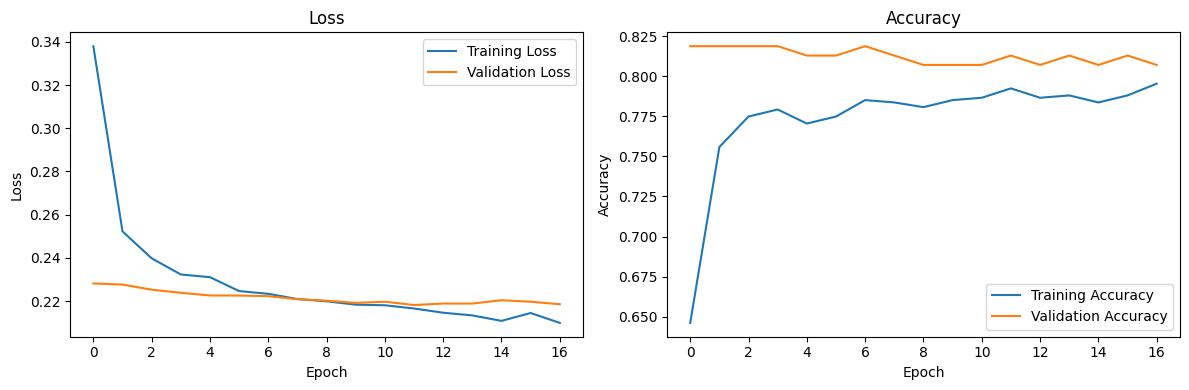

In [ ]:
# Set up callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Fine-tune the model by unfreezing some layers
def fine_tune_model(model):
    # Find the base model - in this case it's ResNet50
    # First, check the model architecture to locate the base model
    for layer in model.layers:
        if hasattr(layer, 'layers'):  # Find the ResNet50 layer
            base_model_layer = layer
            break

    # If we found a base model with layers, unfreeze some of its later layers
    if 'base_model_layer' in locals():
        # Unfreeze the last 20 layers of the base model
        for layer in base_model_layer.layers[-20:]:
            layer.trainable = True
    else:
        # Alternative approach: directly access layers by index or name
        # Typically, the first several layers are from the base model
        for layer in model.layers[1:]:  # Skip input layer
            if len(model.layers) - model.layers.index(layer) <= 20:  # Last 20 layers
                layer.trainable = True

    # Recompile with a lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Fine-tune the model
fine_tuned_model = fine_tune_model(model)

# Train the fine-tuned model
fine_tune_history = fine_tuned_model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

# Evaluate the model
def evaluate_model(model, dataset, mlb):
    """Evaluate model performance on a dataset"""
    # Get predictions
    y_pred_probs = model.predict(dataset)

    # Convert probabilities to binary predictions (threshold = 0.5)
    y_pred = (y_pred_probs > 0.5).astype(int)

    # Get true labels
    y_true = np.vstack([y for _, y in dataset.as_numpy_iterator()])

    # Compute classification report
    report = classification_report(
        y_true,
        y_pred,
        target_names=mlb.classes_,
        zero_division=0
    )

    print("Classification Report:")
    print(report)

    # Compute accuracy for each sample (all labels must match)
    sample_accuracy = np.mean(np.all(y_true == y_pred, axis=1))
    print(f"Exact Match Accuracy: {sample_accuracy:.4f}")

    return y_pred, y_true

# Evaluate on validation set
y_pred, y_true = evaluate_model(fine_tuned_model, val_dataset, mlb)


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 34s 821ms/step - accuracy: 0.7678 - loss: 0.3107 - val_accuracy: 0.8187 - val_loss: 0.2484
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 311ms/step - accuracy: 0.7823 - loss: 0.2096 - val_accuracy: 0.8187 - val_loss: 0.2428
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 307ms/step - accuracy: 0.7842 - loss: 0.1932 - val_accuracy: 0.8187 - val_loss: 0.2419
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 269ms/step - accuracy: 0.7886 - loss: 0.1774 - val_accuracy: 0.8070 - val_loss: 0.2495
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 292ms/step - accuracy: 0.7948 - loss: 0.1590 - val_accuracy: 0.7427 - val_loss: 0.2660
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 303ms/step - accuracy: 0.7810 - loss: 0.1395 - val_accuracy: 0.4386 - val_loss: 0.2883
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 266ms/step - accuracy: 0.8171 - loss: 0.1208 - val_accuracy: 0.2982 - val_loss: 0.3367
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 301ms/step - accuracy: 0.7919 - loss: 0.1132 - val_accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Image: image1022.png
True scan types: ['CT']
Predicted scan types: ['CT' 'MR']
Prediction probabilities: [0.68363506 0.02080023 0.5657898  0.47364852 0.21097223 0.0223966
 0.11085273 0.00410453 0.0689114  0.01960285 0.00460951 0.00808587
 0.00226869]
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Image: image1046.png
True scan types: ['CT', 'Tomography', 'Magnetic resonance']
Predicted scan types: ['CT' 'MR']
Prediction probabilities: [0.73932207 0.0224183  0.58531076 0.4786343  0.23125814 0.02575209
 0.08861655 0.00453848 0.1410608  0.02063183 0.00571079 0.01169804
 0.00456501]
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Image: image1108.png
True scan types: ['CT', 'MRI', 'Tomography', 'Magnetic resonance', 'MR']
Predicted scan types: ['CT' 'MR']
Prediction probabilities: [0.7105087  0.01557051 0.55057263 0.45572785 0.17279257 0.01645149
 0.1026512  0.00264113 0

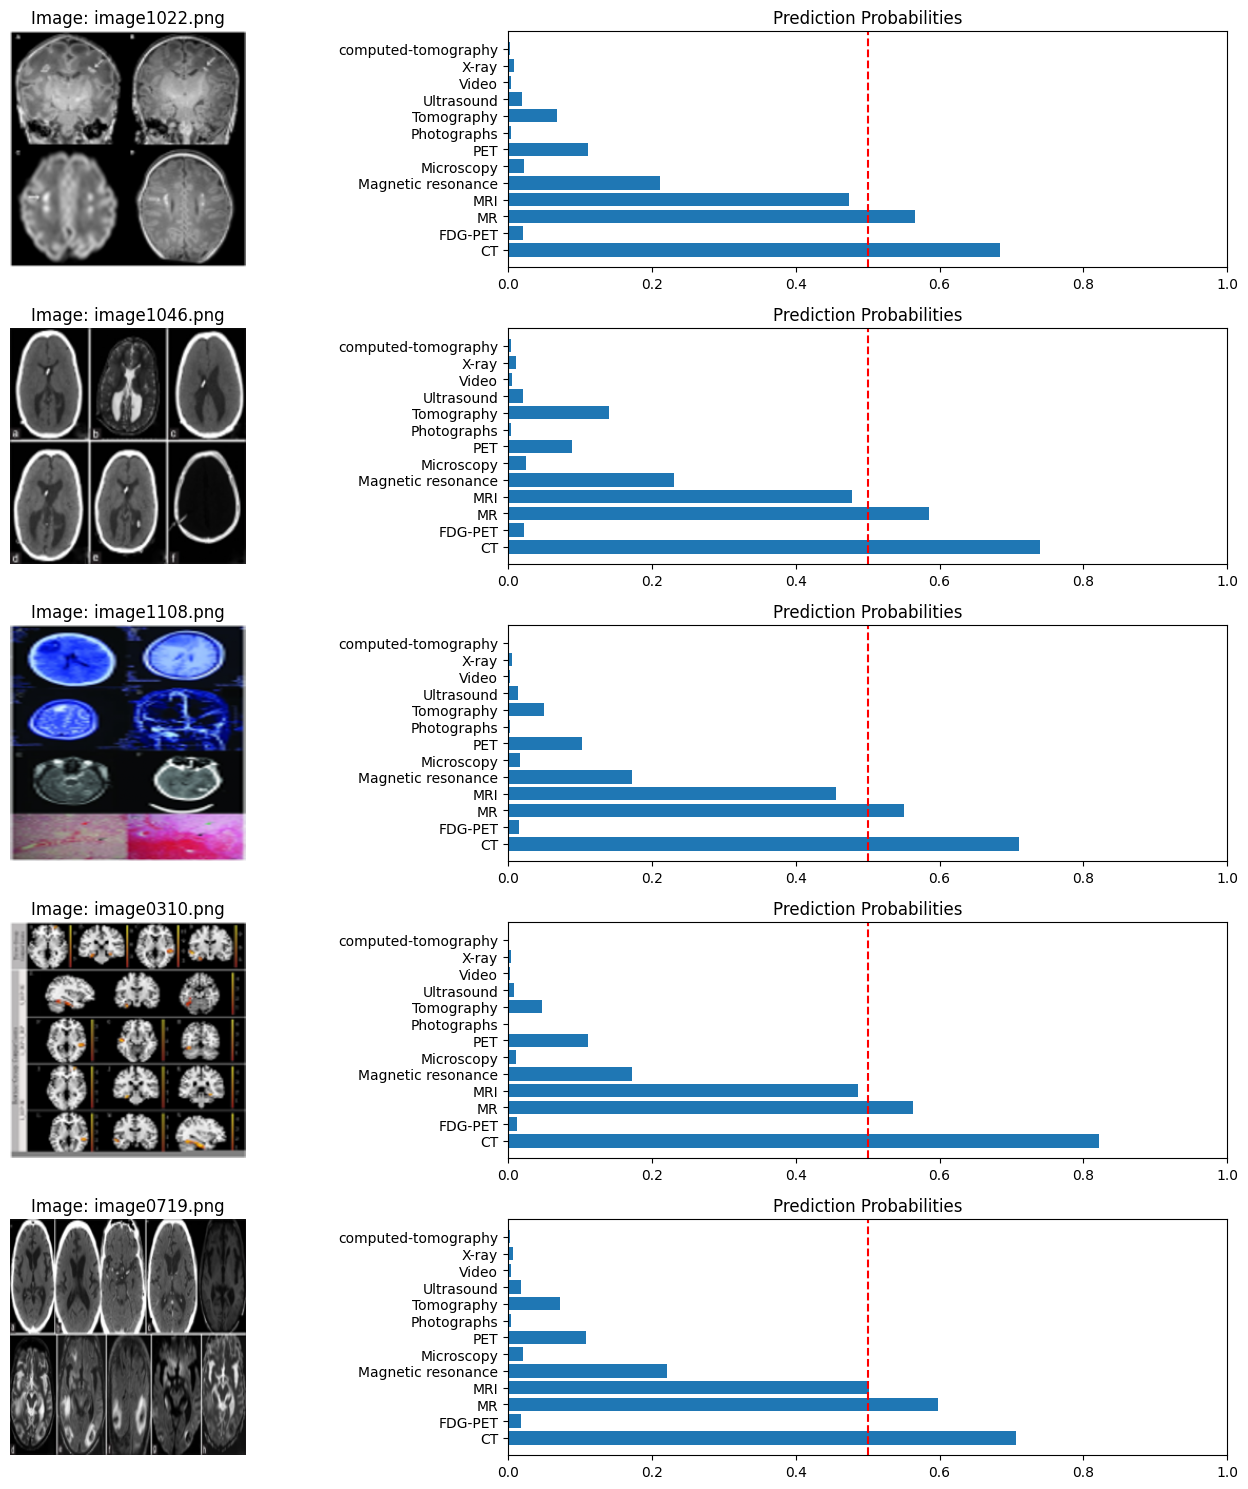

In [ ]:
def visualize_predictions(df, original_df, images_folder, model, mlb, num_samples=5):
    """Visualize model predictions on random samples"""
    # Select random samples
    sample_indices = np.random.choice(len(df), num_samples, replace=False)
    sample_df = df.iloc[sample_indices]

    plt.figure(figsize=(15, num_samples * 3))

    for i, (_, row) in enumerate(sample_df.iterrows()):
        # Get image name
        img_name = row['Image Name']

        # Find corresponding row in original dataframe to get true classes
        orig_row = original_df[original_df['Image Name'] == img_name].iloc[0]
        true_classes = orig_row['scan_types_list']

        # Load and preprocess image
        image_path = os.path.join(images_folder, img_name)
        img_array = load_and_preprocess_image(image_path)

        if img_array is None:
            continue

        # Predict
        prediction = model.predict(np.expand_dims(img_array, axis=0))[0]
        pred_classes = mlb.classes_[prediction > 0.5]

        # Display image and predictions
        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(img_array)
        plt.title(f"Image: {img_name}")
        plt.axis('off')

        plt.subplot(num_samples, 2, 2*i + 2)
        plt.barh(mlb.classes_, prediction)
        plt.axvline(x=0.5, color='r', linestyle='--')
        plt.xlim(0, 1)
        plt.title('Prediction Probabilities')

        print(f"Image: {img_name}")
        print(f"True scan types: {true_classes}")
        print(f"Predicted scan types: {pred_classes}")
        print(f"Prediction probabilities: {prediction}")
        print("-" * 50)

    plt.tight_layout()
    plt.show()

# Visualize some predictions with the modified function
visualize_predictions(val_df, df, images_folder, fine_tuned_model, mlb)